In [2]:
import numpy as np
import torch
from torch import nn, optim

from sklearn import decomposition
from sklearn.datasets import fetch_openml

import matplotlib.pyplot as plt

In [ ]:
import os, ssl
if (not os.environ.get('PYTHONHTTPSVERIFY', '') and
    getattr(ssl, '_create_unverified_context', None)): 
    ssl._create_default_https_context = ssl._create_unverified_context

# 1. Help Functions

In [5]:
def downloadMNIST():
  """
  Download MNIST dataset and transform it to torch.Tensor

  Args:
    None

  Returns:
    x_train : training images (torch.Tensor) (60000, 28, 28)
    x_test  : test images (torch.Tensor) (10000, 28, 28)
    y_train : training labels (torch.Tensor) (60000, )
    y_train : test labels (torch.Tensor) (10000, )
  """
  X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
  # Trunk the data
  n_train = 60000
  n_test = 10000

  train_idx = np.arange(0, n_train)
  test_idx = np.arange(n_train, n_train + n_test)

  x_train, y_train = X[train_idx], y[train_idx]
  x_test, y_test = X[test_idx], y[test_idx]

  # Transform np.ndarrays to torch.Tensor
  x_train = torch.from_numpy(np.reshape(x_train,
                                        (len(x_train),
                                         28, 28)).astype(np.float32))
  x_test = torch.from_numpy(np.reshape(x_test,
                                       (len(x_test),
                                        28, 28)).astype(np.float32))

  y_train = torch.from_numpy(y_train.astype(int))
  y_test = torch.from_numpy(y_test.astype(int))

  return (x_train, y_train, x_test, y_test)



# 3. Download the MNIST Dataset

In [15]:
# Download MNIST
x_train, y_train, x_test, y_test = downloadMNIST()

x_train = x_train / 255
x_test = x_test / 255

image_shape = x_train.shape[1:]

input_size = np.prod(image_shape)

input_train = x_train.reshape([-1, input_size])
input_test = x_test.reshape([-1, input_size])

test_selected_idx = np.random.choice(len(x_test), 10, replace=False)
train_selected_idx = np.random.choice(len(x_train), 10, replace=False)

print(f'shape x_train \t\t {x_train.shape}')
print(f'shape x_test \t\t {x_test.shape}')
print(f'shape image \t\t {image_shape}')
print(f'shape input_train \t {input_train.shape}')
print(f'shape input_test \t {input_test.shape}')

shape x_train 		 torch.Size([60000, 28, 28])
shape x_test 		 torch.Size([10000, 28, 28])
shape image 		 torch.Size([28, 28])
shape input_train 	 torch.Size([60000, 784])
shape input_test 	 torch.Size([10000, 784])


# 4. Show some images

In [154]:
def plot_row(images, orig_labels=None, show_n=10, image_shape=None):
  """
  Plots rows of images from list of iterables (iterables: list, numpy array
  or torch.Tensor). Also accepts single iterable.
  Randomly selects images in each list element if item count > show_n.

  Args:
    images (iterable or list of iterables)
        single iterable with images, or list of iterables

    show_n (integer)
        maximum number of images per row

    image_shape (tuple or list)
        original shape of image if vectorized form

  Returns:
    Nothing.
  """

  if not isinstance(images, (list, tuple)):
    images = [images]
    if orig_labels is not None:
        orig_labels = [orig_labels]

  for items_idx, items in enumerate(images):
    
    if orig_labels is not None:
        labels = orig_labels[items_idx]

    items = np.array(items)
    
    if orig_labels is not None:
        labels = np.array(labels)
        
    if items.ndim == 1:
      items = np.expand_dims(items, axis=0)
    
      if orig_labels is not None:
          labels = np.expand_dims(labels, axis=0)

    if len(items) > show_n:
      selected = np.random.choice(len(items), show_n, replace=False)
      items = items[selected]
        
      if orig_labels is not None:
          labels = labels[selected]

    if image_shape is not None:
      items = items.reshape([-1] + list(image_shape))

    plt.figure(figsize=(len(items) * 1.5, 2))
    for image_idx, image in enumerate(items):

      ax = plt.subplot(1, len(items), image_idx + 1)
      plt.imshow(image, cmap='gray', vmin=image.min(), vmax=image.max())
#       plt.imshow(image, vmin=image.min(), vmax=image.max())
      plt.axis('off')
#       ax.title.set_text(labels[image_idx])

      if orig_labels is not None:
          ax.set_title(labels[image_idx], size=30)

      plt.tight_layout()

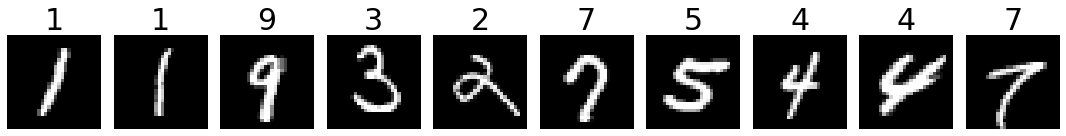

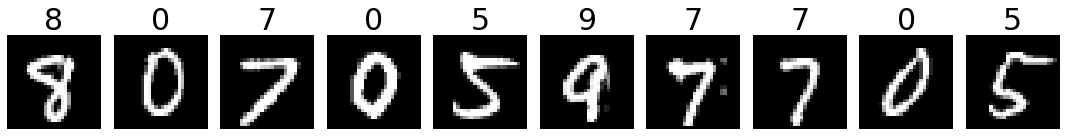

In [155]:
plot_row([x_test, x_test[test_selected_idx]], 
         orig_labels=[y_test, y_test[test_selected_idx]])

# 5. Use PCA to map Input high dimensional space into 2D latent space and plot the output

## 5.1 Use sklearn PCA to decompose into 2D latent space and plot it. 
https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA

### Plot PCA cumulated sum
https://vitalflux.com/pca-explained-variance-concept-python-example/

In [86]:
def xy_lim(x):
  """
  Return arguments for plt.xlim and plt.ylim calculated from minimum
  and maximum of x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        data to be plotted

  Returns:
    Nothing.
  """

  x_min = np.min(x, axis=0)
  x_max = np.max(x, axis=0)

  x_min = x_min - np.abs(x_max - x_min) * 0.05 - np.finfo(float).eps
  x_max = x_max + np.abs(x_max - x_min) * 0.05 + np.finfo(float).eps

  return [x_min[0], x_max[0]], [x_min[1], x_max[1]]


def plot_generative(x, decoder_fn, image_shape, n_row=16):
  """
  Plots images reconstructed by decoder_fn from a 2D grid in
  latent space that is determined by minimum and maximum values in x.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    n_row
        number of rows in grid

  Returns:
    Nothing.
  """

  xlim, ylim = xy_lim(np.array(x))

  dx = (xlim[1] - xlim[0]) / n_row
  grid = [np.linspace(ylim[0] + dx / 2, ylim[1] - dx / 2, n_row),
          np.linspace(xlim[0] + dx / 2, xlim[1] - dx / 2, n_row)]

  canvas = np.zeros((image_shape[0]*n_row, image_shape[1] * n_row))

  cmap = plt.get_cmap('gray')

  for j, latent_y in enumerate(grid[0][::-1]):
    for i, latent_x in enumerate(grid[1]):

      latent = np.array([[latent_x, latent_y]], dtype=np.float32)
      with torch.no_grad():
          x_decoded = decoder_fn(torch.from_numpy(latent))

      x_decoded = x_decoded.reshape(image_shape)

      canvas[j*image_shape[0]: (j + 1) * image_shape[0],
             i*image_shape[1]: (i + 1) * image_shape[1]] = x_decoded

  plt.imshow(canvas, cmap=cmap, vmin=canvas.min(), vmax=canvas.max())
  plt.axis('off')


def plot_latent(x, y, show_n=500, fontdict=None, xy_labels=None):
  """
  Plots digit class of each sample in 2D latent space coordinates.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    n_row (integer)
        number of samples

    fontdict (dictionary)
        optional style option for plt.text

    xy_labels (list)
        optional list with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  if fontdict is None:
    fontdict = {'weight': 'bold', 'size': 12}

  cmap = plt.get_cmap('tab10')

  if len(x) > show_n:
    selected = np.random.choice(len(x), show_n, replace=False)
    x = x[selected]
    y = y[selected]

  for my_x, my_y in zip(x, y):
    plt.text(my_x[0], my_x[1], str(int(my_y)),
             color=cmap(int(my_y) / 10.),
             fontdict=fontdict,
             horizontalalignment='center',
             verticalalignment='center',
             alpha=0.8)

  if xy_labels is None:
    xy_labels = ['$Z_1$', '$Z_2$']

  plt.xlabel(xy_labels[0])
  plt.ylabel(xy_labels[1])

  xlim, ylim = xy_lim(np.array(x))
  plt.xlim(xlim)
  plt.ylim(ylim)


def plot_latent_generative(x, y, decoder_fn, image_shape, title=None,
                           xy_labels=None):
  """
  Two horizontal subplots generated with encoder map and decoder grid.

  Args:
    x (list, numpy array or torch.Tensor of floats)
        2D coordinates in latent space

    y (list, numpy array or torch.Tensor of floats)
        digit class of each sample

    decoder_fn (integer)
        function returning vectorized images from 2D latent space coordinates

    image_shape (tuple or list)
        original shape of image

    title (string)
        plot title

    xy_labels (list)
        optional lsit with [xlabel, ylabel]

  Returns:
    Nothing.
  """

  fig = plt.figure(figsize=(12, 6))

  if title is not None:
    fig.suptitle(title, y=1.05)

  ax = fig.add_subplot(121)
  ax.set_title('Encoder map', y=1.05)
  plot_latent(x, y, xy_labels=xy_labels)

  ax = fig.add_subplot(122)
  ax.set_title('Decoder grid', y=1.05)
  plot_generative(x, decoder_fn, image_shape)

  plt.tight_layout()
  plt.show()

In [127]:
pca = decomposition.PCA(n_components=2)
pca.fit(input_train)
pca_latent_test = pca.transform(input_test)

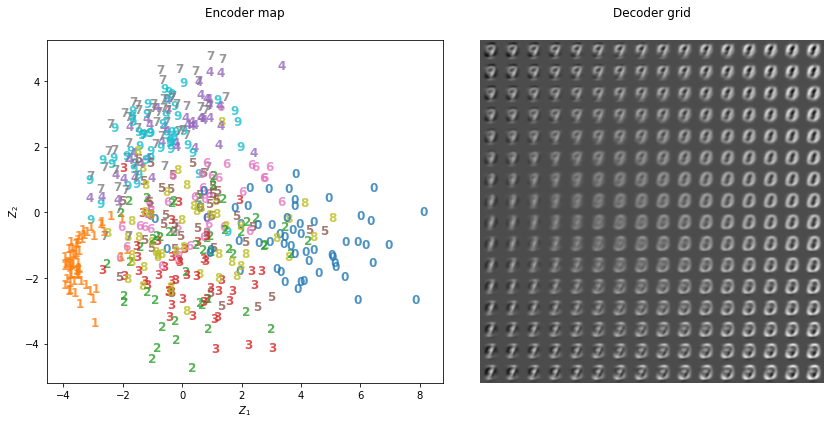

In [128]:
plot_latent_generative(pca_latent_test, y_test, pca.inverse_transform,
                       image_shape=image_shape)

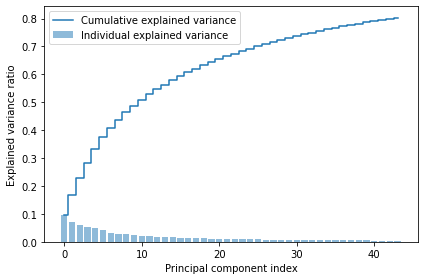

In [129]:
pca_80 = decomposition.PCA(0.8)
pca_80.fit(input_train)

exp_var_pca = pca_80.explained_variance_ratio_
cum_sum_eigenvalues = np.cumsum(exp_var_pca)

plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# 5.2 Qualitative Analysis PCA

### a. First, print the PCA components

### b. Try to inverse convert the latent space back to the input and print it

(2, 784)


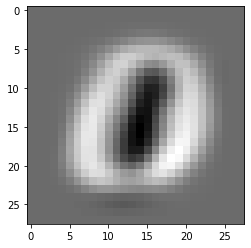

In [151]:
# Try one
print(pca.components_.shape)
img = pca.components_[0]
img = img.reshape(image_shape)
plt.imshow(img, cmap='gray', vmin=img.min(), vmax=img.max())

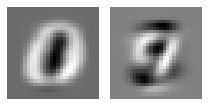

In [156]:
plot_row(pca.components_, image_shape=image_shape)

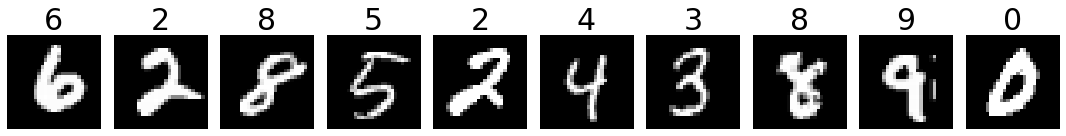

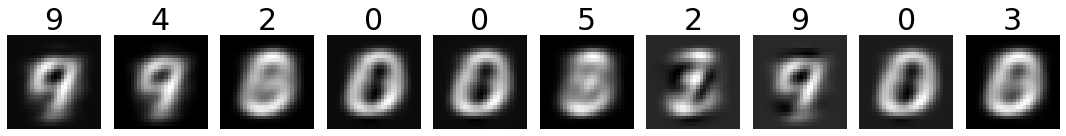

In [157]:
# Note, this is only using 2D
inversed_pca_test = pca.inverse_transform(pca_latent_test)
plot_row([input_test, inversed_pca_test],
         [y_test, y_test], image_shape=image_shape)

# 6. Now, implement an ANN Autoencoder

In [189]:
# Build the Model

class ANN_Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_size):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_size, encoding_size),
            nn.ReLU(),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(encoding_size, input_size),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# 7. Now, train the model

In [192]:
def eval_mse(y_pred, y_true):
  """
  Evaluates Mean Square Error (MSE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    MSE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = nn.MSELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)


def eval_bce(y_pred, y_true):
  """
  Evaluates Binary Cross-Entropy (BCE) between y_pred and y_true

  Args:
    y_pred (torch.Tensor)
        prediction samples

    v (numpy array of floats)
        ground truth samples

  Returns:
    BCE(y_pred, y_true)
  """

  with torch.no_grad():
      criterion = nn.BCELoss()
      loss = criterion(y_pred, y_true)

  return float(loss)

def runSGD(net, input_train, input_test, criterion='bce',
           n_epochs=10, batch_size=32, verbose=False):
  """
  Trains autoencoder network with stochastic gradient descent with Adam
  optimizer and loss criterion. Train samples are shuffled, and loss is
  displayed at the end of each opoch for both MSE and BCE. Plots training loss
  at each minibatch (maximum of 500 randomly selected values).

  Args:
    net (torch network)
        ANN object (nn.Module)

    input_train (torch.Tensor)
        vectorized input images from train set

    input_test (torch.Tensor)
        vectorized input images from test set

    criterion (string)
        train loss: 'bce' or 'mse'

    n_epochs (boolean)
        number of full iterations of training data

    batch_size (integer)
        number of element in mini-batches

    verbose (boolean)
        whether to print final loss

  Returns:
    Nothing.
  """

  # Initialize loss function
  if criterion == 'mse':
    loss_fn = nn.MSELoss()
  elif criterion == 'bce':
    loss_fn = nn.BCELoss()
  else:
    print('Please specify either "mse" or "bce" for loss criterion')

  # Initialize SGD optimizer
  optimizer = optim.Adam(net.parameters())

  # Placeholder for loss
  track_loss = []

  print('Epoch', '\t', 'Loss train', '\t', 'Loss test')
  for i in range(n_epochs):

    shuffle_idx = np.random.permutation(len(input_train))
    batches = torch.split(input_train[shuffle_idx], batch_size)

    for batch in batches:

      output_train = net(batch)
      loss = loss_fn(output_train, batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Keep track of loss at each epoch
      track_loss += [float(loss)]

    loss_epoch = f'{i + 1} / {n_epochs}'
    with torch.no_grad():
      output_train = net(input_train)
      loss_train = loss_fn(output_train, input_train)
      loss_epoch += f'\t {loss_train:.4f}'

      output_test = net(input_test)
      loss_test = loss_fn(output_test, input_test)
      loss_epoch += f'\t\t {loss_test:.4f}'

    print(loss_epoch)

  if verbose:
    # Print final loss
    loss_mse = f'\nMSE\t {eval_mse(output_train, input_train):0.4f}'
    loss_mse += f'\t\t {eval_mse(output_test, input_test):0.4f}'
    print(loss_mse)

    loss_bce = f'BCE\t {eval_bce(output_train, input_train):0.4f}'
    loss_bce += f'\t\t {eval_bce(output_test, input_test):0.4f}'
    print(loss_bce)

  # Plot loss
  step = int(np.ceil(len(track_loss) / 500))
  x_range = np.arange(0, len(track_loss), step)
  plt.figure()
  plt.plot(x_range, track_loss[::step], 'C0')
  plt.xlabel('Iterations')
  plt.ylabel('Loss')
  plt.xlim([0, None])
  plt.ylim([0, None])
  plt.show()

In [193]:
encoding_size = 32
model = ANN_Autoencoder(np.prod(image_shape), encoding_size)
print(model)

ANN_Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=784, bias=True)
    (1): Sigmoid()
  )
)


Epoch 	 Loss train 	 Loss test
1 / 10	 0.0212		 0.0208
2 / 10	 0.0190		 0.0185
3 / 10	 0.0182		 0.0178
4 / 10	 0.0179		 0.0175
5 / 10	 0.0177		 0.0173
6 / 10	 0.0176		 0.0172
7 / 10	 0.0176		 0.0172
8 / 10	 0.0175		 0.0172
9 / 10	 0.0174		 0.0171
10 / 10	 0.0174		 0.0171


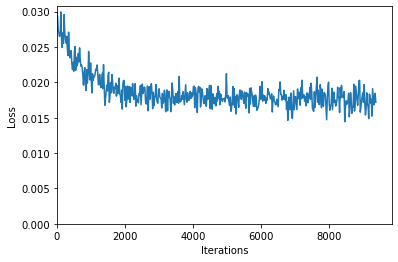

In [195]:
n_epochs = 10
batch_size = 64

runSGD(model, input_train, input_test, criterion='mse',
       n_epochs=n_epochs, batch_size=batch_size)

# 8. Test the model with the test data

In [202]:
with torch.no_grad():
  output_test = model(input_test)

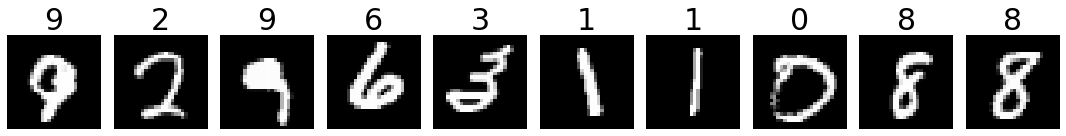

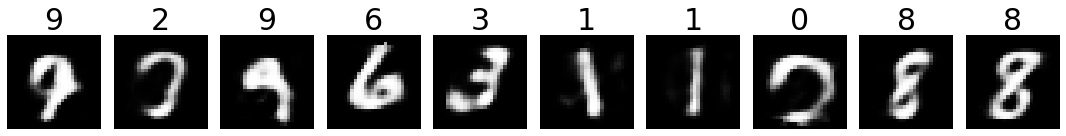

In [206]:

final_test_idx = np.random.choice(len(input_test), 10, replace=False)
plot_row([input_test[final_test_idx], output_test[final_test_idx]],
         orig_labels=[y_test[final_test_idx], y_test[final_test_idx]],
         image_shape=image_shape)

ANN_Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=784, bias=True)
    (1): Sigmoid()
  )
)
Epoch 	 Loss train 	 Loss test
1 / 2	 0.0263		 0.0260
2 / 2	 0.0188		 0.0185


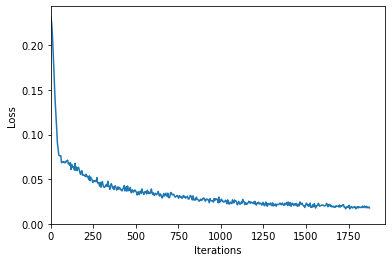

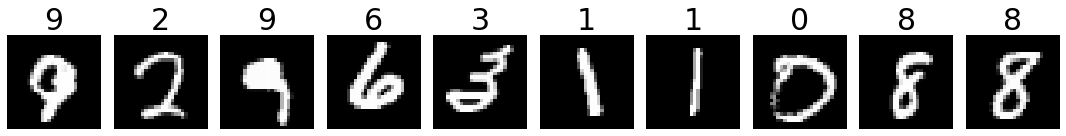

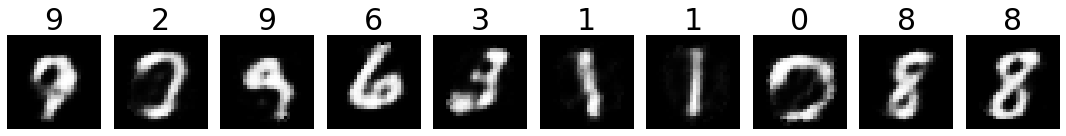

In [207]:
encoding_size = 32
model = ANN_Autoencoder(np.prod(image_shape), encoding_size)
print(model)

n_epochs = 2
batch_size = 64

runSGD(model, input_train, input_test, criterion='mse',
       n_epochs=n_epochs, batch_size=batch_size)

with torch.no_grad():
  output_test = model(input_test)

# final_test_idx = np.random.choice(len(input_test), 10, replace=False)
plot_row([input_test[final_test_idx], output_test[final_test_idx]],
         orig_labels=[y_test[final_test_idx], y_test[final_test_idx]],
         image_shape=image_shape)

ANN_Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=32, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=784, bias=True)
    (1): Sigmoid()
  )
)
Epoch 	 Loss train 	 Loss test
1 / 2	 0.1547		 0.1531
2 / 2	 0.1241		 0.1224


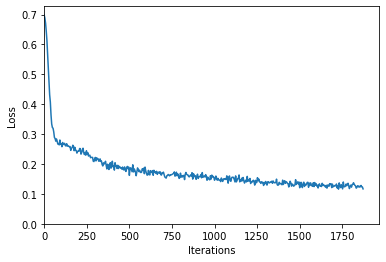

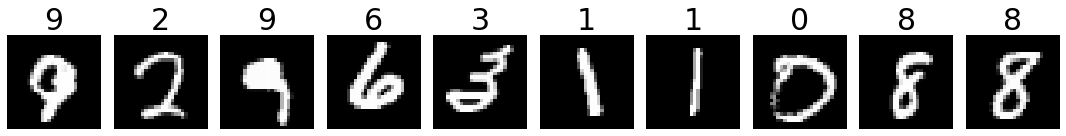

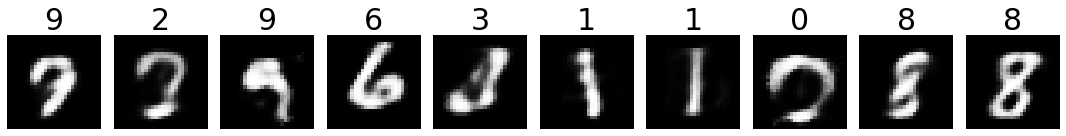

In [208]:
encoding_size = 32
model = ANN_Autoencoder(np.prod(image_shape), encoding_size)
print(model)

n_epochs = 2
batch_size = 64

runSGD(model, input_train, input_test, criterion='bce',
       n_epochs=n_epochs, batch_size=batch_size)

with torch.no_grad():
  output_test = model(input_test)

# final_test_idx = np.random.choice(len(input_test), 10, replace=False)
plot_row([input_test[final_test_idx], output_test[final_test_idx]],
         orig_labels=[y_test[final_test_idx], y_test[final_test_idx]],
         image_shape=image_shape)